In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

from pymutspec.draw import plot_mutspec12
from pymutspec.annotation import CodonAnnotation
from pymutspec.constants import possible_codons

from calculate_exp_aa_subst_matrix import (
    amino_acid_codes, alphabet, cdn_spectrum_to_matrix, 
    nuc_spectrum_to_matrix, collect_possible_changes,
    get_equilibrium_probabilities
)

In [10]:
coda = CodonAnnotation(1)

In [12]:
## read external clades spectra
# https://raw.githubusercontent.com/jbloomlab/SARS2-mut-spectrum/refs/heads/main/results/synonymous_mut_rates/rates_by_clade.csv

clades_spectra = pd.read_csv('data/rates_by_clade.csv')
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')
spectrum_20A = clades_spectra[clades_spectra['clade'] == '20A']
spectrum_20A

,clade,mut_type,count,total_count,fraction,parent_nt,parent_nt_frac,rate,Mut
0,20A,AtoC,286,17202,0.016626,A,0.289620,0.057407,A>C
1,20A,AtoG,1617,17202,0.094001,A,0.289620,0.324570,A>G
2,20A,AtoT,515,17202,0.029938,A,0.289620,0.103370,A>T
3,20A,CtoA,339,17202,0.019707,C,0.137040,0.143810,C>A
4,20A,CtoG,130,17202,0.007557,C,0.137040,0.055147,C>G
5,20A,CtoT,7113,17202,0.413500,C,0.137040,3.017400,C>T
6,20A,GtoA,837,17202,0.048657,G,0.064987,0.748720,G>A
7,20A,GtoC,137,17202,0.007964,G,0.064987,0.122550,G>C
8,20A,GtoT,2670,17202,0.155210,G,0.064987,2.388400,G>T
9,20A,TtoA,565,17202,0.032845,T,0.508360,0.064610,T>A


In [14]:
df_changes = collect_possible_changes()
clade_specific_spectrum = spectrum_20A.set_index('Mut').rate.to_dict()

## Calculate codon and aa equilibrium frequencies
df_changes['rate'] = df_changes['sbs'].map(clade_specific_spectrum)
cdn_sbs = df_changes.groupby(['cdn1', 'cdn2'])['rate'].sum()
M = cdn_spectrum_to_matrix(cdn_sbs)
eq_prob = get_equilibrium_probabilities(M).astype(float)

eq_freqs_cdn = pd.Series(dict(zip(possible_codons, eq_prob)))
eq_freqs_cdn.name = 'freq'
eq_freqs_cdn.index.name = 'cdn'
eq_freqs_cdn = eq_freqs_cdn.reset_index()
eq_freqs_cdn['aa'] = eq_freqs_cdn['cdn'].map(coda.translate_codon).map(amino_acid_codes)

eq_freqs_cdn.to_csv('./data/cdn_eq_freqs.csv', index=False, float_format='%g')
eq_freqs_cdn

,cdn,freq,aa
0,AAA,0.004267,Lys
1,AAC,0.001897,Asn
2,AAG,0.000726,Lys
3,AAT,0.019418,Asn
4,ACA,0.001897,Thr
...,...,...,...
59,TGT,0.015035,Cys
60,TTA,0.088360,Leu
61,TTC,0.039289,Phe
62,TTG,0.015035,Leu


In [27]:
eq_freqs_cdn.sort_values(['aa', 'freq']).iloc[3:]

,cdn,freq,aa
38,GCG,0.000055,Ala
37,GCC,0.000144,Ala
36,GCA,0.000323,Ala
39,GCT,0.001469,Ala
26,CGG,0.000055,Arg
...,...,...,...
51,TAT,0.088360,Tyr
46,GTG,0.000562,Val
45,GTC,0.001469,Val
44,GTA,0.003304,Val


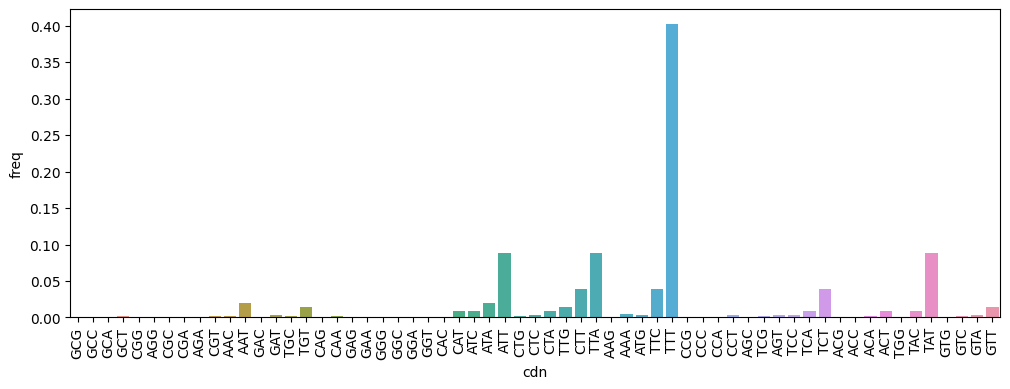

In [31]:
plt.figure(figsize=(12, 4))
sns.barplot(data=eq_freqs_cdn.sort_values(['aa', 'freq']).iloc[3:], 
            y='freq', x='cdn', )
plt.xticks(rotation=90);

In [32]:
eq_freqs_aa = eq_freqs_cdn[eq_freqs_cdn.aa !='*'].groupby('aa')['freq'].sum()
eq_freqs_aa /= eq_freqs_aa.sum()
eq_freqs_aa = eq_freqs_aa.sort_values(ascending=False).reset_index()
eq_freqs_aa.to_csv('./data/aa_eq_freqs.csv', index=False)
eq_freqs_aa

,aa,freq
0,Phe,0.453163
1,Leu,0.160812
2,Ile,0.119522
3,Tyr,0.099586
4,Ser,0.058378
5,Asn,0.021885
6,Val,0.020914
7,Cys,0.016945
8,Thr,0.012011
9,His,0.009731


In [41]:
# https://media.githubusercontent.com/media/jbloomlab/SARS2-mut-spectrum/refs/heads/main/results/mutation_counts/aggregated.csv
obs = pd.read_csv('data/aggregated.csv')
obs = obs[(obs.subset == 'all') & (obs['exclude'] == False) & (~obs.protein.isin(['ORF7a;ORF7b', 'ORF1a;ORF1ab;ORF1ab']))]
# obs['Mut'] = obs['mut_type'].str.replace('to', '>')
obs

,protein,aa_mutation,nt_mutation,codon_change,synonymous,count,nt_site,reference_nt,clade_founder_nt,exclude,exclude_reason,clade,subset,codon_position,four_fold_degenerate
0,ORF1ab,P5401L,C16466T,CCA>CTA,False,62,16466,C,C,False,NaN,19A,all,2,False
1,M,I82T,T26767C,ATC>ACC,False,54,26767,T,T,False,NaN,19A,all,2,False
2,ORF1a;ORF1ab,F924F;F924F,C3037T,TTC>TTT;TTC>TTT,True,49,3037,C,C,False,NaN,19A,all,3,False
3,ORF1ab,A6319V,C19220T,GCT>GTT,False,46,19220,C,C,False,NaN,19A,all,2,False
4,ORF1ab,I5658V,A17236G,ATA>GTA,False,45,17236,A,A,False,NaN,19A,all,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979832,ORF1a;ORF1ab,T2825N;T2825N,C8739A,ACT>AAT;ACT>AAT,False,1,8739,C,C,False,NaN,22C,all,2,False
979833,ORF1a;ORF1ab,T2836A;T2836A,A8771G,ACA>GCA;ACA>GCA,False,1,8771,A,A,False,NaN,22C,all,1,False
979834,ORF1a;ORF1ab,T2836T;T2836T,A8773C,ACA>ACC;ACA>ACC,True,1,8773,A,A,False,NaN,22C,all,3,True
979835,ORF1a;ORF1ab,T283N;T283N,C1113A,ACT>AAT;ACT>AAT,False,1,1113,C,C,False,NaN,22C,all,2,False


In [55]:
obs[obs.aa_mutation.apply(lambda x: len(set(x.split(';')))) > 1]

,protein,aa_mutation,nt_mutation,codon_change,synonymous,count,nt_site,reference_nt,clade_founder_nt,exclude,exclude_reason,clade,subset,codon_position,four_fold_degenerate
27354,ORF1a;ORF1ab,G4402G;V4403I,G13471A,GGG>GGA;GTT>ATT,False,1,13471,G,G,False,NaN,20A,all,mixed,False
28126,ORF1a;ORF1ab,F4403L;V4403A,T13472C,TTT>CTT;GTT>GCT,False,1,13472,T,T,False,NaN,20A,all,mixed,False
31047,ORF1a;ORF1ab,A4404S;C4404F,G13475T,GCG>TCG;TGC>TTC,False,1,13475,G,G,False,NaN,20A,all,mixed,False
32292,ORF1a;ORF1ab;ORF1ab,N4401N;N4401N;R4402W,C13468T,AAC>AAT;AAC>AAT;CGG>TGG,False,1,13468,C,C,False,NaN,20A,all,mixed,False
66957,ORF7a;ORF7b,E121E;M1V,A27756G,GAA>GAG;ATG>GTG,False,2,27756,A,A,False,NaN,20B,all,mixed,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959120,ORF1a;ORF1ab,G4402G;V4403I,G13471A,GGG>GGA;GTT>ATT,False,7,13471,G,G,False,NaN,22C,all,mixed,False
971874,ORF7a;ORF7b,E121D;M1L,A27756T,GAA>GAT;ATG>TTG,False,1,27756,A,A,False,NaN,22C,all,mixed,False
971879,ORF7a;ORF7b,E121D;M1L,A27756C,GAA>GAC;ATG>CTG,False,1,27756,A,A,False,NaN,22C,all,mixed,False
973422,ORF1a;ORF1ab,F4403L;C4404S,T13474A,TTT>TTA;TGC>AGC,False,1,13474,T,T,False,NaN,22C,all,mixed,False


In [52]:
obs.aa_mutation.apply(lambda x: len(set(x.split(';')))).value_counts()

1    451688
2       101
Name: aa_mutation, dtype: int64

In [45]:
obs.protein.value_counts()

ORF1a;ORF1ab           202060
ORF1ab                 104086
S                       60071
N                       25888
ORF3a                   19229
M                        9977
ORF7a                    9462
ORF8                     8518
ORF6                     3977
E                        3319
ORF7b                    2867
ORF10                    2307
ORF7a;ORF7b                24
ORF1a;ORF1ab;ORF1ab         4
Name: protein, dtype: int64

In [44]:
# same as in the paper table
obs[obs.four_fold_degenerate].groupby('clade')['count'].sum().sort_index()

clade
19A      1601
20A     17202
20B     14123
20C      9348
20E     10455
20F       550
20G     14021
20I     60867
20J      4237
21C      6310
21F      4819
21I     24128
21J    282108
21K    113757
21L     83486
22A     11413
22B     64767
22C     18961
Name: count, dtype: int64